# History of pollen levels in Eugene, OR

### The usual imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import datetime

%matplotlib inline

### Some parameters for plotting and labeling

In [2]:
cols = ['trees', 'weeds', 'grass']
col_labels = {'trees': 'Tree pollen', 'weeds': 'Weed pollen', 'grass': 'Grass pollen'}
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthdays = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
monthstartdays = np.cumsum([0] + monthdays[:-1]) + 1
pollen_levels = ['no count', 'low', 'moderate', 'high', 'very high']

### Smoothing functions

In [3]:
def padded_array(x, pad):
    return np.concatenate((np.ones(pad) * x[0], x, np.ones(pad) * x[-1]))

def smooth(x, kernel, w, pad):
    kernel /= kernel.sum()
    x_smooth = np.convolve(x, kernel, mode='same')
    std = np.sqrt(np.convolve((x - x_smooth)**2, kernel, mode='same'))
    if pad > 0:
        x_smooth = x_smooth[pad:-pad]
    if pad > 0:
        std = std[pad:-pad]
    return x_smooth, std

def boxsmooth(x, w=1, pad=0):
    x_padded = padded_array(x, pad)
    kernel = np.ones(w) / w
    return smooth(x_padded, kernel, w, pad)

def gsmooth(x, w=1, pad=0, kernel_threshold=1e-5):
    x_padded = padded_array(x, pad)
    kernel_x = np.linspace(-x.size, x.size, x_padded.size)
    sigma = w / (2 * np.sqrt(2 * np.log(2)))
    kernel = np.exp(-kernel_x**2 / (2 * sigma**2))
    kernel[kernel < kernel_threshold] = 0
    return smooth(x_padded, kernel, w, pad)

### Load data

In [4]:
df = pd.read_csv('data/eug-or.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df = df[~((df.index.month == 2) & (df.index.day > 28))]

# All 19 years of pollen counts

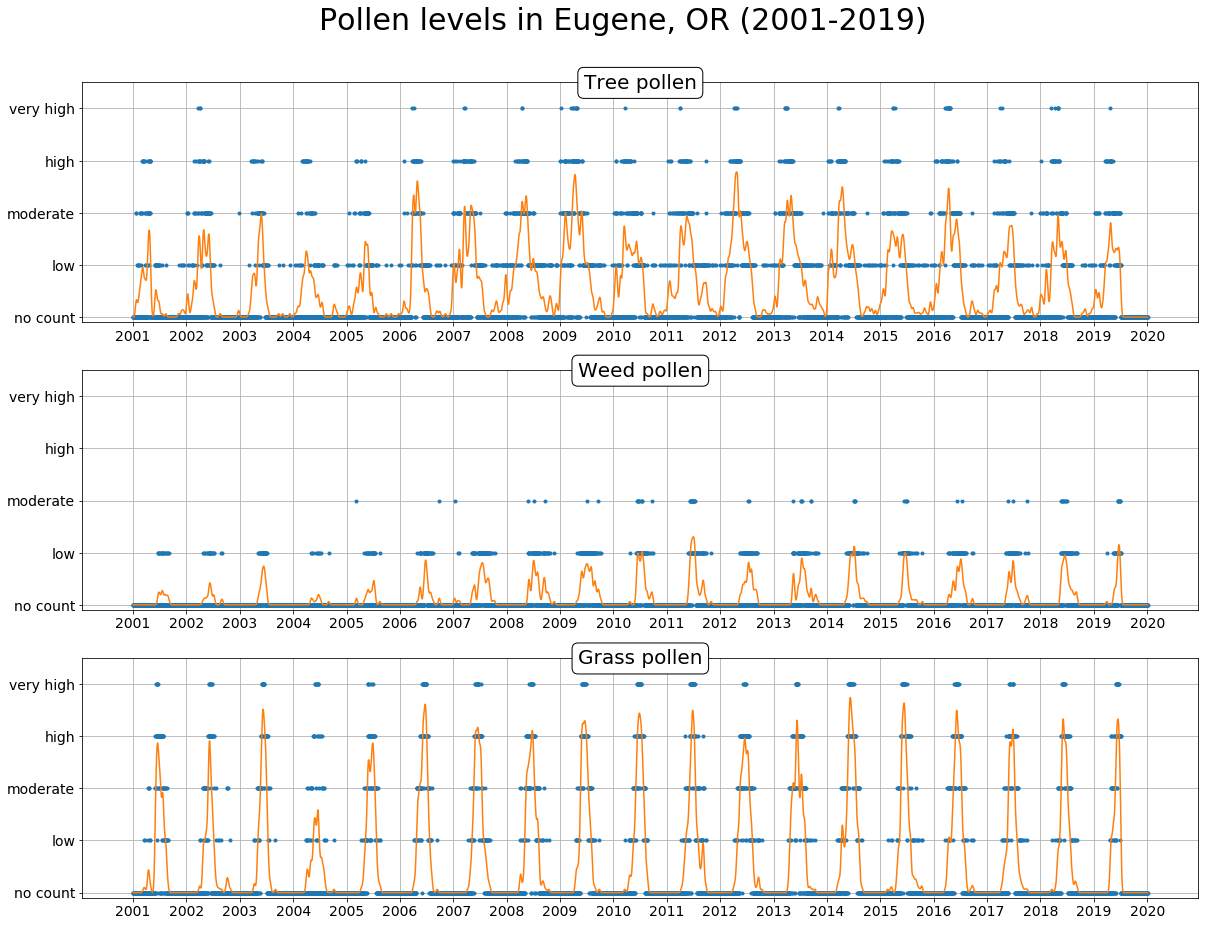

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
fig.suptitle("Pollen levels in Eugene, OR (2001-2019)", y=0.95, fontsize=30)
for i, col in enumerate(cols):
    values = df[col]
    values_smooth, _ = gsmooth(df[col].values, w=30)
    x = (df.index - df.index[0]).days
    ax[i].plot(x, values, '.')
    ax[i].plot(x, values_smooth, '-')
    ax[i].tick_params(labelsize=14)
    ax[i].set_xticks(range(x[0], x[-1], 365))
    ax[i].set_xticklabels(range(2001, 2021))
    ax[i].set_yticks(range(len(pollen_levels)))
    ax[i].set_yticklabels(pollen_levels)
    ax[i].set_title(col_labels[col], y=0.95, bbox=dict(boxstyle='round', facecolor='w'), size=20)
    ax[i].set_ylim(-0.1, 4.5)
    ax[i].grid()
fig.savefig('plots/eug-or-full.png')
fig.show()

# Monthly averages over 19 years

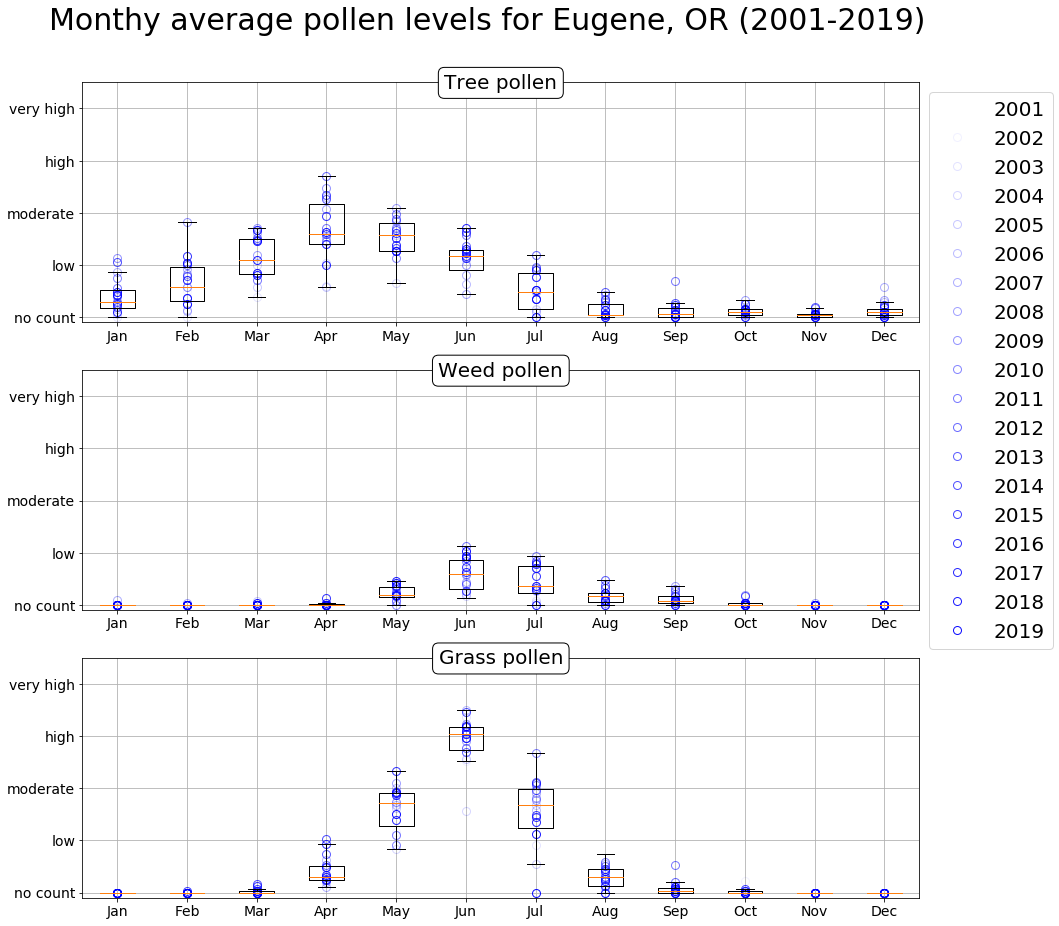

In [6]:
pv = pd.pivot_table(df, index=df.index.month, columns=df.index.year, values=cols, aggfunc='mean')
fig, ax = plt.subplots(len(cols), 1, figsize=(15, 15))
fig.suptitle("Monthy average pollen levels for Eugene, OR (2001-2019)", y=0.95, fontsize=30)
for i, col in enumerate(cols):
    years = pv[col].columns
    mean = np.mean(pv[col].values, axis=1)
    for j, year in enumerate(years):
        alpha = j / len(years)
        ax[i].plot(range(1, 13), pv[col][year].values, 'o', markersize=8, markerfacecolor='none', markeredgecolor='b', alpha=alpha, label=year)
    ax[i].boxplot(pv[col], sym='')
#     ax[i].plot(mean, lw=5, ls=':', label='mean')
    ax[i].set_title(col_labels[col], y=0.95, bbox=dict(boxstyle='round', facecolor='w'), size=20)
    ax[i].tick_params(labelsize=14)
    ax[i].set_xticks(range(1, 13))
    ax[i].set_xticklabels(months)
    ax[i].set_yticks(range(len(pollen_levels)))
    ax[i].set_yticklabels(pollen_levels)
    ax[i].set_ylim(-0.1, 4.5)
    if i == 0:
        ax[i].legend(bbox_to_anchor=(1, 1), fontsize=20)
    ax[i].grid()
fig.savefig('plots/eug-or-monthly.png')
fig.show()

# Daily averages over 19 years

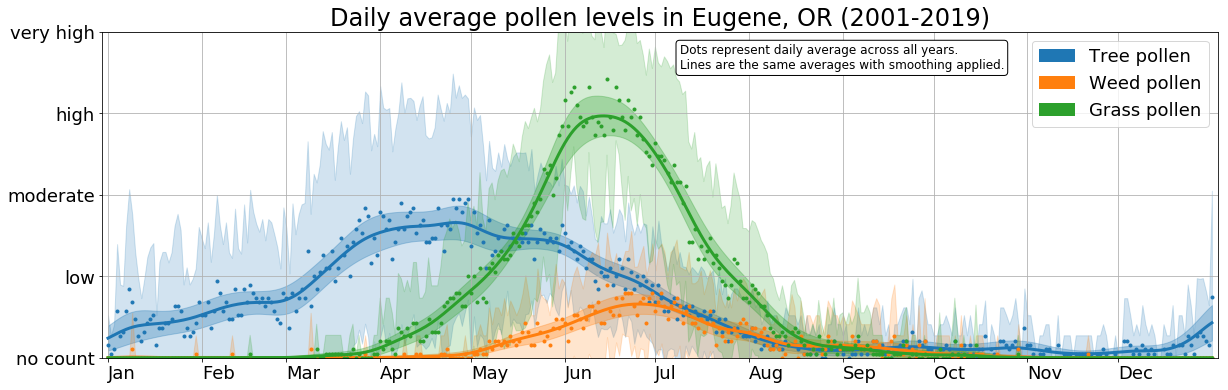

In [7]:
pv = pd.pivot_table(df, index=df.index.dayofyear, columns=df.index.year, values=cols, aggfunc='mean')
w = 30
pad = 10
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
means = []
lgd_patches = []
lgd_labels = []
for col in cols:
    days = pv.index
    mean = pv[col].mean(axis=1)
    means.append(mean)
    std = np.std(pv[col], axis=1)
    lower_bound = mean - std
    upper_bound = mean + std
    line, = ax.plot([], [])
    color = line.get_color()
    lgd_patches.append(mpatches.Patch(facecolor=color))
    label = col_labels[col] #col[0].upper() + col[1:]
    lgd_labels.append(label)
    ax.plot(days, mean.values, '.', color=color)
    ax.fill_between(x=days, y1=lower_bound, y2=upper_bound, color=color, alpha=0.2)
    mean_boxsmooth, std_boxsmooth = boxsmooth(mean.values, w=w, pad=pad)
    mean_gsmooth, std_gsmooth = gsmooth(mean.values, w=w, pad=pad)
    lower_bound = mean_gsmooth - std_gsmooth
    upper_bound = mean_gsmooth + std_gsmooth
#     ax.plot(days, mean_boxsmooth, '--', lw=3, color=color)
    ax.plot(days, mean_gsmooth, lw=3, color=color)
    ax.fill_between(x=days, y1=lower_bound, y2=upper_bound, color=color, alpha=0.3)
ax.set_title('Daily average pollen levels in Eugene, OR (2001-2019)', size=24)
ax.tick_params(labelsize=18)
ax.set_xticks(monthstartdays)
ax.set_xticklabels(months, ha='left')
ax.set_yticks(range(5))
ax.set_yticklabels(['no count', 'low', 'moderate', 'high', 'very high'])
ax.set_xlim(-1, 368)
ax.set_ylim(0, 4)
ax.legend(lgd_patches, lgd_labels, bbox_to_anchor=(1, 1), fontsize=18)
text_str = "Dots represent daily average across all years.\nLines are the same averages with smoothing applied."
text_bbox = dict(boxstyle='round', facecolor='w')
ax.text(190, 3.85, text_str, va='top', bbox=text_bbox, size=12)
ax.grid()
fig.savefig('plots/eug-or-daily.png')
fig.show()